<a href="https://colab.research.google.com/github/diego-mogollon/lateguru/blob/conor-data-modelling/Lateguru_Modelling_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries & Datasets**

This notebook models flight delays using binary classification with two models:
- A dense neural network with a sigmoid activation function
- A Support Vector Model Classifier (SVM) ML model

In [2]:
#importing python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#import xgboost as xgb

#from imblearn.over_sampling import SMOTE, ADASYN


In [3]:
from google.colab import drive


# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

'''
# Specify the path to your CSV file (replace with your actual path)
X_test_preprocessed = '/content/drive/MyDrive/Lateguru/data/X_test_preprocessed_dt.csv'
X_train_preprocessed = '/content/drive/MyDrive/Lateguru/data/X_train_balanced_dt.csv'
y_test_sample = '/content/drive/MyDrive/Lateguru/data/y_test_sample_dt.csv'
y_train_sample = '/content/drive/MyDrive/Lateguru/data/y_train_balanced_dt.csv'''

# Specify the path to your CSV file (replace with your actual path)
# - Lighter csvs with smaller dimensionality
X_test_preprocessed_lite = '/content/drive/MyDrive/Lateguru/data/X_test_preprocessed_dt_lite.csv'
X_train_preprocessed_lite = '/content/drive/MyDrive/Lateguru/data/X_train_balanced_dt_lite.csv'
y_test_sample_lite = '/content/drive/MyDrive/Lateguru/data/y_test_sample_dt_lite.csv'
y_train_sample_lite = '/content/drive/MyDrive/Lateguru/data/y_train_balanced_dt_lite.csv'

'''# Read the CSV file into a Pandas DataFrame
X_test_preprocessed_df = pd.read_csv(X_test_preprocessed, compression='zip')
X_train_preprocessed_df = pd.read_csv(X_train_preprocessed,compression='zip')
y_test_sample_df = pd.read_csv(y_test_sample, compression='zip')
y_train_sample_df = pd.read_csv(y_train_sample, compression='zip')'''

# Read the CSV file into a Pandas DataFrame
X_test_preprocessed_df = pd.read_csv(X_test_preprocessed_lite, compression='zip')
X_train_preprocessed_df = pd.read_csv(X_train_preprocessed_lite,compression='zip')
y_test_sample_df = pd.read_csv(y_test_sample_lite, compression='zip')
y_train_sample_df = pd.read_csv(y_train_sample_lite, compression='zip')

# Print the first few rows of the DataFrame
print(X_test_preprocessed_df.head(1))
print(X_train_preprocessed_df.head(1))
print(y_test_sample_df.head(1))
print(y_train_sample_df.head(1))

     0    1    2    3    4    5    6    7    8    9  ...        19        20  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.746967  0.617834   

         21        22        23        24        25        26        27  \
0 -0.005274 -0.179188 -0.526035 -0.198035 -0.012081 -0.934971  0.510185   

         28  
0  0.390438  

[1 rows x 29 columns]
     0    1    2    3    4    5    6    7    8    9  ...        19        20  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.400392 -1.406217   

         21        22        23        24        25        26        27  \
0  0.418044 -1.726217  1.161871 -0.198035 -0.012081  1.450462 -1.490332   

         28  
0 -0.193089  

[1 rows x 29 columns]
   Delayed
0     True
   Delayed
0     True


In [5]:
y_test_sample_df.value_counts(normalize=True)

,proportion
Delayed,
False,0.610717
True,0.389283


In [6]:
y_train_sample_df.value_counts(normalize=True)

,proportion
Delayed,
False,0.5
True,0.5


In [7]:
y_test_sample_df['Delayed'] = y_test_sample_df['Delayed'].apply(lambda x: 1 if x == True else 0)
y_train_sample_df['Delayed'] = y_train_sample_df['Delayed'].apply(lambda x: 1 if x == True else 0)

In [8]:
X_test_preprocessed_arr = np.array(X_test_preprocessed_df)
X_train_preprocessed_arr = np.array(X_train_preprocessed_df)
y_test_sample_arr = np.array(y_test_sample_df)
y_train_sample_arr = np.array(y_train_sample_df)


In [7]:
print(f"X_test_preprocessed shape: {X_test_preprocessed_arr.shape}")
print(f"X_train_preprocessed shape: {X_train_preprocessed_arr.shape}")
print(f"y_test_sample shape: {y_test_sample_arr.shape}")
print(f"y_train_sample shape: {y_train_sample_arr.shape}")


X_test_preprocessed shape: (90867, 29)
X_train_preprocessed shape: (443956, 29)
y_test_sample shape: (90867, 1)
y_train_sample shape: (443956, 1)


In [7]:
y_train_sample_arr = y_train_sample_arr.reshape(-1)


In [9]:
#splitting the test data into a validation set to ensure no data leakage during nn training
#make sure to evaluate the model on X_test_sample_nn

X_val, X_test_sample_nn, y_val, y_test_sample_nn = train_test_split(X_test_preprocessed_arr, y_test_sample_arr,
                 test_size=0.5,
                 random_state=42,
                 stratify=y_test_sample_arr)

In [11]:
pd.DataFrame(y_val).value_counts(normalize=True)

,proportion
0,
0,0.610723
1,0.389277


In [13]:
pd.DataFrame(y_test_sample_nn).value_counts(normalize=True)

,proportion
0,
0,0.61071
1,0.38929


In [9]:
print(f"X_val shape: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test_sample_nn shape: {X_test_sample_nn.shape}")
print(f"y_test_sample_nn: {y_test_sample_nn.shape}")

X_val shape: (45433, 29)
y_val: (45433, 1)
X_test_sample_nn shape: (45434, 29)
y_test_sample_nn: (45434, 1)


 #  **Modelling with a SVM Classifier**

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix



In [9]:
sig_svm_clf = SVC(kernel='rbf')

In [ ]:
sig_svm_clf.fit(X_train_preprocessed_arr, y_train_sample_arr)

In [ ]:
y_pred = sig_svm_clf.predict(X_test_preprocessed)

In [ ]:
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_test_sample, y_pred)
print(f"F1 score: {f1}")

# **Modelling with a Dense Neural Network**

In [10]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop


# Assuming you have your input data prepared


model = Sequential()
model.add(layers.Dense(411,activation='tanh', input_dim=X_train_preprocessed_arr.shape[1]))
model.add(layers.Dense(256,activation='tanh'))
model.add(layers.Dense(128,activation='relu'))
#model.add(layers.Dense(128,activation='tanh'))
model.add(layers.Dense(64,activation='tanh'))
model.add(layers.Dense(32,activation='tanh')) #regularise some layers, try tanh a bit
model.add(layers.Dense(16,activation='tanh'))
model.add(layers.Dense(8,activation='tanh'))
model.add(layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 411)                 │          12,330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         105,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,707 (631.67 KB)

 Trainable params: 161,707 (631.67 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
adam = Adam(
    learning_rate=0.001
)

RMSprop = RMSprop(
    learning_rate=0.001
)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', 'recall', 'precision', 'f1_score'])


#optimise learning rates by splitting out adam

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

In [12]:
#Need to manually define a balanced validation set

In [14]:
history = model.fit(X_train_preprocessed_arr, y_train_sample_arr, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks =[es])

Epoch 1/10
13874/13874 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.6127 - f1_score: 0.6672 - loss: 0.6558 - precision: 0.6242 - recall: 0.5690 - val_accuracy: 0.6551 - val_f1_score: 0.5604 - val_loss: 0.6344 - val_precision: 0.5782 - val_recall: 0.4211
Epoch 2/10
13874/13874 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.6239 - f1_score: 0.6665 - loss: 0.6468 - precision: 0.6394 - recall: 0.5679 - val_accuracy: 0.6348 - val_f1_score: 0.5604 - val_loss: 0.6402 - val_precision: 0.5283 - val_recall: 0.5781
Epoch 3/10
11671/13874 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6237 - f1_score: 0.6649 - loss: 0.6468 - precision: 0.6329 - recall: 0.5821

KeyboardInterrupt: 

In [110]:
history.history

{'accuracy': [0.6353504061698914,
  0.6430694460868835,
  0.6469691395759583,
  0.6484639048576355,
  0.6504167914390564,
  0.6526467800140381,
  0.6533644199371338,
  0.6546003222465515,
  0.6561005115509033,
  0.6569147706031799,
  0.658674418926239,
  0.6592122912406921,
  0.6609543561935425,
  0.6617165803909302,
  0.663149893283844,
  0.6637330055236816,
  0.6650304794311523,
  0.6661758422851562,
  0.6671489477157593,
  0.6676151752471924],
 'f1_score': [0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368,
  0.6666666269302368],
 'loss': [0.637505054473877,
  0.6302366256713867,
  0.6272959113121033,
  0.6257428526878357,
 

In [112]:
history.history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall'])

In [114]:
loss, accuracy, recall, precision, f1_score = model.evaluate(X_test_sample_nn, y_test_sample_nn)

print(f"Test loss:{loss}")
print(f"Test recall:{recall}")
print(f"Test accuracy:{accuracy}")
print(f"Test precision:{precision}")
print(f"Test f1 score:{f1_score}")

4733/4733 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6463 - f1_score: 0.5623 - loss: 0.6334 - precision: 0.5428 - recall: 0.6049
Test loss:0.6338878870010376
Test recall:0.6041726469993591
Test accuracy:0.6476961970329285
Test precision:0.5426582098007202
Test f1 score:0.5604060292243958


In [88]:
y_pred = model.predict(X_test_sample_nn)

4733/4733 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [90]:
y_test_sample_nn

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [84]:
y_test_sample_nn

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [45]:
y_pred

array([[0.36575276],
       [0.45286626],
       [0.27189898],
       ...,
       [0.54360294],
       [0.5859621 ],
       [0.37453306]], dtype=float32)

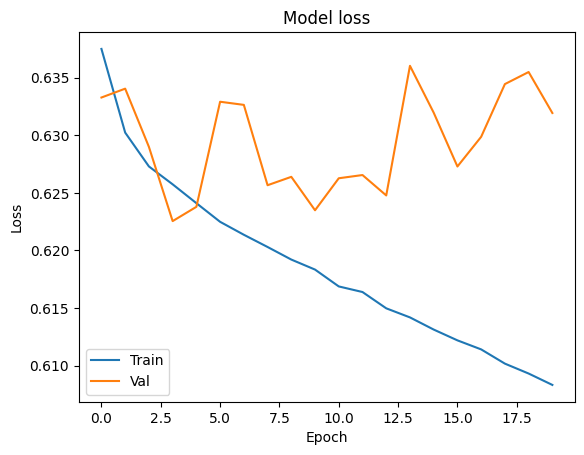

In [123]:
#visualise  graph for overfitting using history

import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()




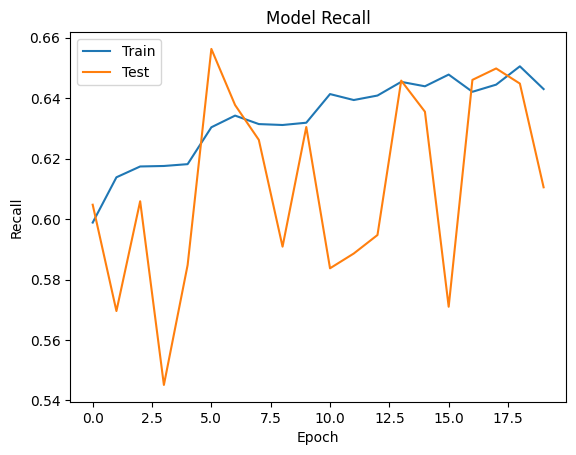

In [124]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [15]:
!git status

fatal: not a git repository (or any of the parent directories): .git
